In [75]:
import pickle
import warnings
import gzip
import random
import ujson

import numpy as np
import networkx as nx
import pandas as pd

from tqdm import tqdm
from glob import glob
from collections import OrderedDict, defaultdict
from scipy import stats
from scipy.spatial import distance
from itertools import combinations
from sklearn import preprocessing

from torch.nn import functional as F

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 500

In [4]:
preds = []

for path in tqdm(glob('../data/embeds-en/*.p')):
    with open(path, 'rb') as fh:
        
        lines = pickle.load(fh)

        for line in lines:
            title = ' '.join(line.pop('tokens'))
            line.pop('embedding')
            preds.append(OrderedDict(title=title, **line))

100%|██████████| 65/65 [00:23<00:00,  2.71it/s]


In [8]:
actors = defaultdict(set)

for path in tqdm(glob('../data/link-actor-graph.json/*.gz')):
    with gzip.open(path, 'rb') as fh:
        for line in fh:
            r = ujson.loads(line)
            actors[r['domain']].add(r['actor_id'])

100%|██████████| 10/10 [00:41<00:00,  4.13s/it]


In [9]:
domains = list(set([r['label'] for r in preds]))

In [10]:
domains

['breitbart.com',
 'washingtonpost.com',
 'buzzfeed.com',
 'dailykos.com',
 'dailycaller.com',
 'apnews.com',
 'bloomberg.com',
 'huffingtonpost.com',
 'foxnews.com',
 'thehill.com',
 'nytimes.com',
 'wsj.com',
 'cnn.com']

# Actor jaccard sim

In [73]:
def jaccard_sim(s1, s2):
    return len(set.intersection(s1, s2)) / len(set.union(s1, s2))

In [95]:
rows = []
for d1, d2 in tqdm(combinations(domains, 2)):
    d = jaccard_sim(actors[d1], actors[d2])
    rows.append((d1, d2, d))

78it [00:42,  1.07it/s]


In [97]:
df_actors = pd.DataFrame(rows, columns=('d1', 'd2', 's'))
df_actors['label'] = df_actors[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

In [98]:
scaler = preprocessing.StandardScaler()
df_actors['scaled_sim'] = scaler.fit_transform(np.array(df_actors.s).reshape(-1, 1))

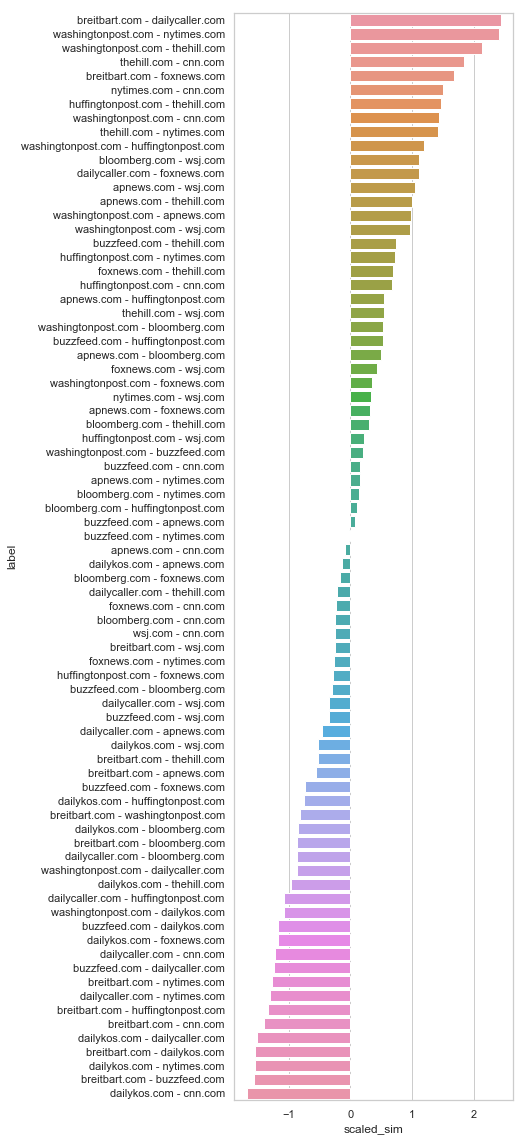

In [99]:
plt.figure(figsize=(5,20))
sns.barplot(x='scaled_sim', y='label', data=df_actors.sort_values('scaled_sim', ascending=False))

# Title pred correlations

In [100]:
def title_corr(d1, d2, metric):
    d1p = [r[f'p_{d1}'] for r in preds]
    d2p = [r[f'p_{d2}'] for r in preds]
    return metric(d1p, d2p)

In [101]:
rows = []
for d1, d2 in tqdm(combinations(domains, 2)):
    c, _ = title_corr(d1, d2, stats.pearsonr)
    rows.append((d1, d2, c))

78it [00:51,  1.50it/s]


In [102]:
df_titles = pd.DataFrame(rows, columns=('d1', 'd2', 's'))
df_titles['label'] = df_titles[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

In [103]:
scaler = preprocessing.StandardScaler()
df_titles['scaled_sim'] = scaler.fit_transform(np.array(df_titles.s).reshape(-1, 1))

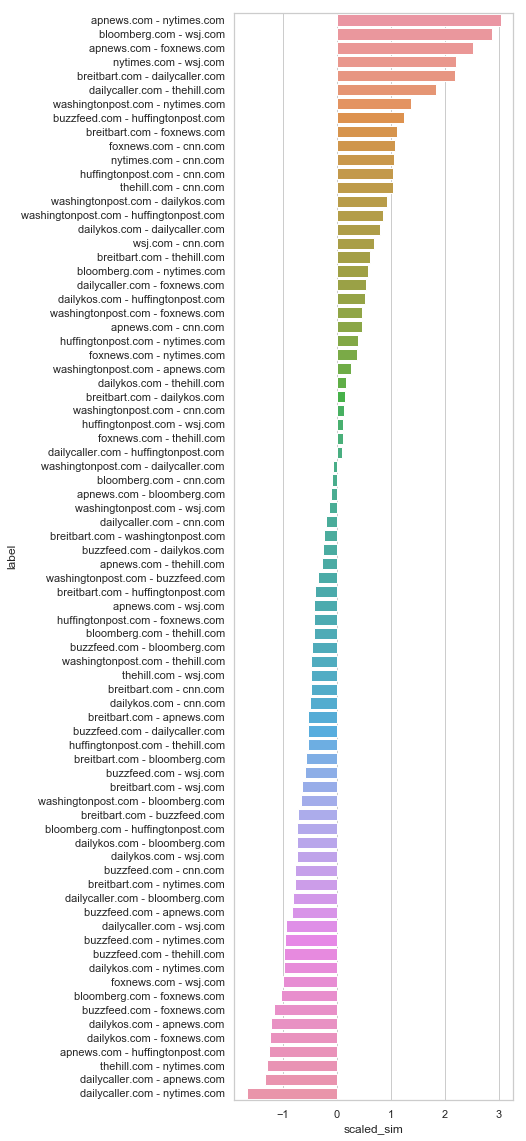

In [104]:
plt.figure(figsize=(5,20))
sns.barplot(x='scaled_sim', y='label', data=df_titles.sort_values('scaled_sim', ascending=False))

In [108]:
sims = df_titles.merge(df_actors, on=('d1', 'd2'), suffixes=('_titles', '_actors'))

In [111]:
sims['s_delta'] = sims['scaled_sim_titles'] - sims['scaled_sim_actors']

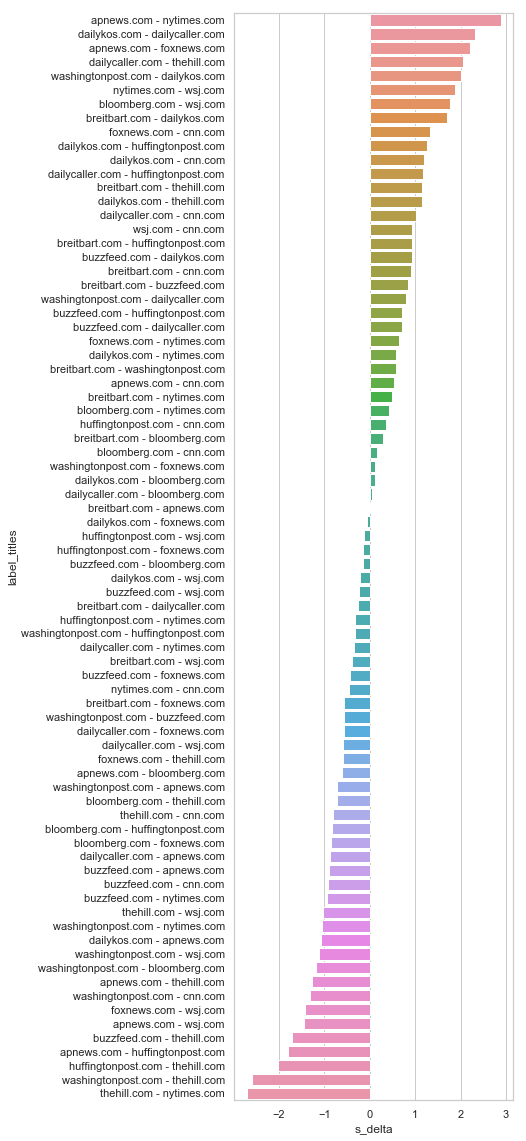

In [117]:
plt.figure(figsize=(5,20))
sns.barplot(x='s_delta', y='label_titles', data=sims.sort_values('s_delta', ascending=False))

In [116]:
sims.sort_values('s_delta', ascending=False)[['d1', 'd2', 'scaled_sim_titles', 'scaled_sim_actors', 's_delta']]

,d1,d2,scaled_sim_titles,scaled_sim_actors,s_delta
54,apnews.com,nytimes.com,3.033151,0.152306,2.880845
33,dailykos.com,dailycaller.com,0.803542,-1.509653,2.313195
52,apnews.com,foxnews.com,2.525860,0.315249,2.210611
46,dailycaller.com,thehill.com,1.835889,-0.219335,2.055223
13,washingtonpost.com,dailykos.com,0.932437,-1.071322,2.003759
75,nytimes.com,wsj.com,2.215742,0.331218,1.884524
61,bloomberg.com,wsj.com,2.875352,1.108748,1.766604
2,breitbart.com,dailykos.com,0.153656,-1.544789,1.698445
71,foxnews.com,cnn.com,1.086992,-0.234209,1.321200
36,dailykos.com,huffingtonpost.com,0.515650,-0.749200,1.264851
